<a href="https://colab.research.google.com/github/ab17254/dissertation/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Upload config.py with API keys
from google.colab import files
uploaded = files.upload()

Saving config.py to config.py


In [2]:
import os
from config import KaggleKey
os.environ['KAGGLE_USERNAME'] = KaggleKey.kaggle_username
os.environ['KAGGLE_KEY'] = KaggleKey.kaggle_key
!kaggle datasets download -d albrace/twitter-data

 99% 771M/780M [00:06<00:00, 152MB/s]
100% 780M/780M [00:06<00:00, 133MB/s]


In [3]:
!unzip /content/twitter-data.zip -d /content/data

Archive:  /content/twitter-data.zip
  inflating: /content/data/2019_all_twitter_data/2019_all_twitter_data.csv  
  inflating: /content/data/bot_df/bot_df.csv  
  inflating: /content/data/clean_twitter_data/all_2019.csv  
  inflating: /content/data/clean_twitter_data/all_users.csv  
  inflating: /content/data/clean_twitter_data/pol_actor_users.csv  
  inflating: /content/data/ge2017_cand_data/ge2017_cand_data.csv  
  inflating: /content/data/twitter_data/all_twitter_data.csv  
  inflating: /content/data/twitter_data/political_twitter_data.csv  


In [4]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3 MB 1.5 MB/s 


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from operator import itemgetter

import re
import tweepy
from tweepy import OAuthHandler
from config import TwitterKeys

In [7]:
pol_df = pd.read_csv('/content/data/bot_df/bot_df.csv', index_col=0)
pol_df = pol_df.reset_index(drop=True)

In [40]:
all_df = pd.read_csv('/content/data/clean_twitter_data/all_2019.csv', index_col=0)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
print(pol_df.shape)
pol_df.isnull().sum()

(2895, 26)


score                            0
tweet_date                       0
tweet_content                    0
tweet_id                         0
tweet_likes                      0
tweet_replies                    0
tweet_retweets                   0
tweet_quotes                     0
user_username                    0
user_id                          0
user_followers                   0
user_friends                     0
user_statuses                    0
user_verified                    0
user_url                         0
tweet_url                        0
quotedTweet_id                   0
quotedTweet_content              0
quotedTweet_username             0
quotedTweet_userID               0
hashtags                         0
quoted_hashtags                  0
clean_tweet_content              0
clean_quotedTweet_content        0
mentioned_users               2315
quotedTweet_mentionedUsers    2384
dtype: int64

In [9]:
pol_df = pol_df.dropna(subset=['quotedTweet_username'])


In [10]:
interactions_df = pd.DataFrame(columns=['user_username', 'quotedTweet_username'])
user = []
mentions = []
for row in pol_df.iterrows():
  user.append(row[1]['user_username'])
  mentions.append(row[1]['quotedTweet_username'])
interactions_df['user_username'] = user
interactions_df['quotedTweet_username'] = mentions
interactions_df['quotedTweet_username'] = interactions_df['quotedTweet_username'].str.split()

In [11]:
interactions_df = interactions_df.dropna()

In [12]:
interactions = []
for row in interactions_df.iterrows():
  user = row[1][0]
  mentions = row[1][1]
  for mention in mentions:
    interactions.append((user, mention))

In [13]:
interactions_df = pd.DataFrame(interactions, columns=['user_username', 'quotedTweet_username'])

In [84]:
interactions_df

,user_username,quotedTweet_username
0,EvadneyC,pauldashworth
3,SirClouseau,pauldashworth
4,Socialistdawn,pauldashworth
5,bcomininvisible,pauldashworth
6,BlackCatz74,pauldashworth
...,...,...
2890,SLOTE3,Gemac91138162
2891,GraniteSharesUK,FTAlphaville
2892,NickPfitzner,heelersbot
2893,JMAG1892_2,binksOutContext


In [15]:
interactions_df = interactions_df.replace('nan', np.nan)
interactions_df = interactions_df.dropna()

In [16]:
interactions_df['user_username'] = interactions_df['user_username'].astype('str')
interactions_df['quotedTweet_username'] = interactions_df['quotedTweet_username'].astype('str')

In [17]:
interactions_df=interactions_df.drop([1,2])

In [61]:
graph = nx.from_pandas_edgelist(interactions_df, 'user_username', 'quotedTweet_username')
pos = nx.spring_layout(graph)

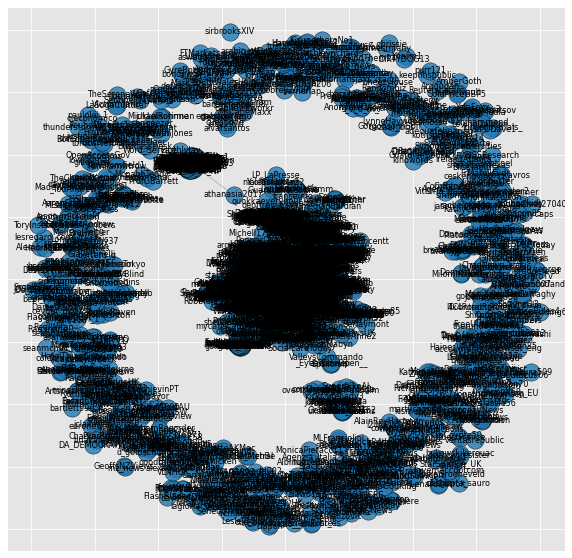

In [62]:
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(graph, pos,
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(graph, pos, font_size=8)
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.2)

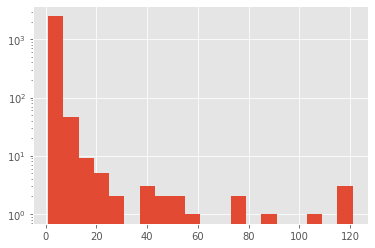

In [79]:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, log=True, bins=20)
    plt.show()

plot_degree_dist(graph)

In [63]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")
degrees = [val for (node, val) in graph.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

There are 2571 nodes and 2541 edges present in the Graph
The maximum degree of the Graph is 121
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 2.0
The most frequent degree of the nodes found in the Graph is 1
The graph is not connected
There are 367 connected components in the Graph


In [64]:
largest_subgraph=list(graph.subgraph(c) for c in nx.connected_components(graph))[0]
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

    
print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")
print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

There are 1692 nodes and 1998 edges present in the largest component of the Graph
The graph is connected
The average clustering coefficient is 0.001870486616054812 in the largest subgraph
The transitivity of the largest subgraph is 0.0007394322803269934
The diameter of our Graph is 14
The average distance between any two nodes is 5.60


In [65]:
graph_centrality = nx.degree_centrality(largest_subgraph)
max_de = max(graph_centrality.items(), key=itemgetter(1))
graph_closeness = nx.closeness_centrality(largest_subgraph)
max_clo = max(graph_closeness.items(), key=itemgetter(1))
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)
max_bet = max(graph_betweenness.items(), key=itemgetter(1))
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id pauldashworth has a degree centrality of 0.07 which is the maximum of the Graph
the node with id pauldashworth has a closeness centrality of 0.30 which is the maximum of the Graph
the node with id pauldashworth has a betweenness centrality of 0.43 which is the maximum of the Graph


In [66]:
betweenness = dict(sorted(graph_betweenness.items(), key=itemgetter(1), reverse=True)[:10])
cent = dict(sorted(graph_centrality.items(), key=itemgetter(1)))

In [71]:
betweenness

{'Cornish_Damo': 0.09435092582877211,
 'FT': 0.155747115219118,
 'GdnPolitics': 0.13461721448773087,
 'KevinPascoe': 0.11531740703336885,
 'LBCNews': 0.07752743889449192,
 'athanasia2017': 0.12990037756448164,
 'bbcelection': 0.1336298328428611,
 'guardiannews': 0.27183402368707293,
 'pauldashworth': 0.4322617215617038,
 'philewis': 0.09784467019302548}

In [99]:
cent = {}
for node in largest_subgraph.nodes():
  if node in interactions_df['quotedTweet_username'].values:
    cent[node] = node

In [107]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['red']
central_nodes = list(cent.keys())
pos = nx.kamada_kawai_layout(largest_subgraph)

In [69]:
labels = {}
for node in largest_subgraph.nodes():
  if node in central_nodes:
    labels[node] = node

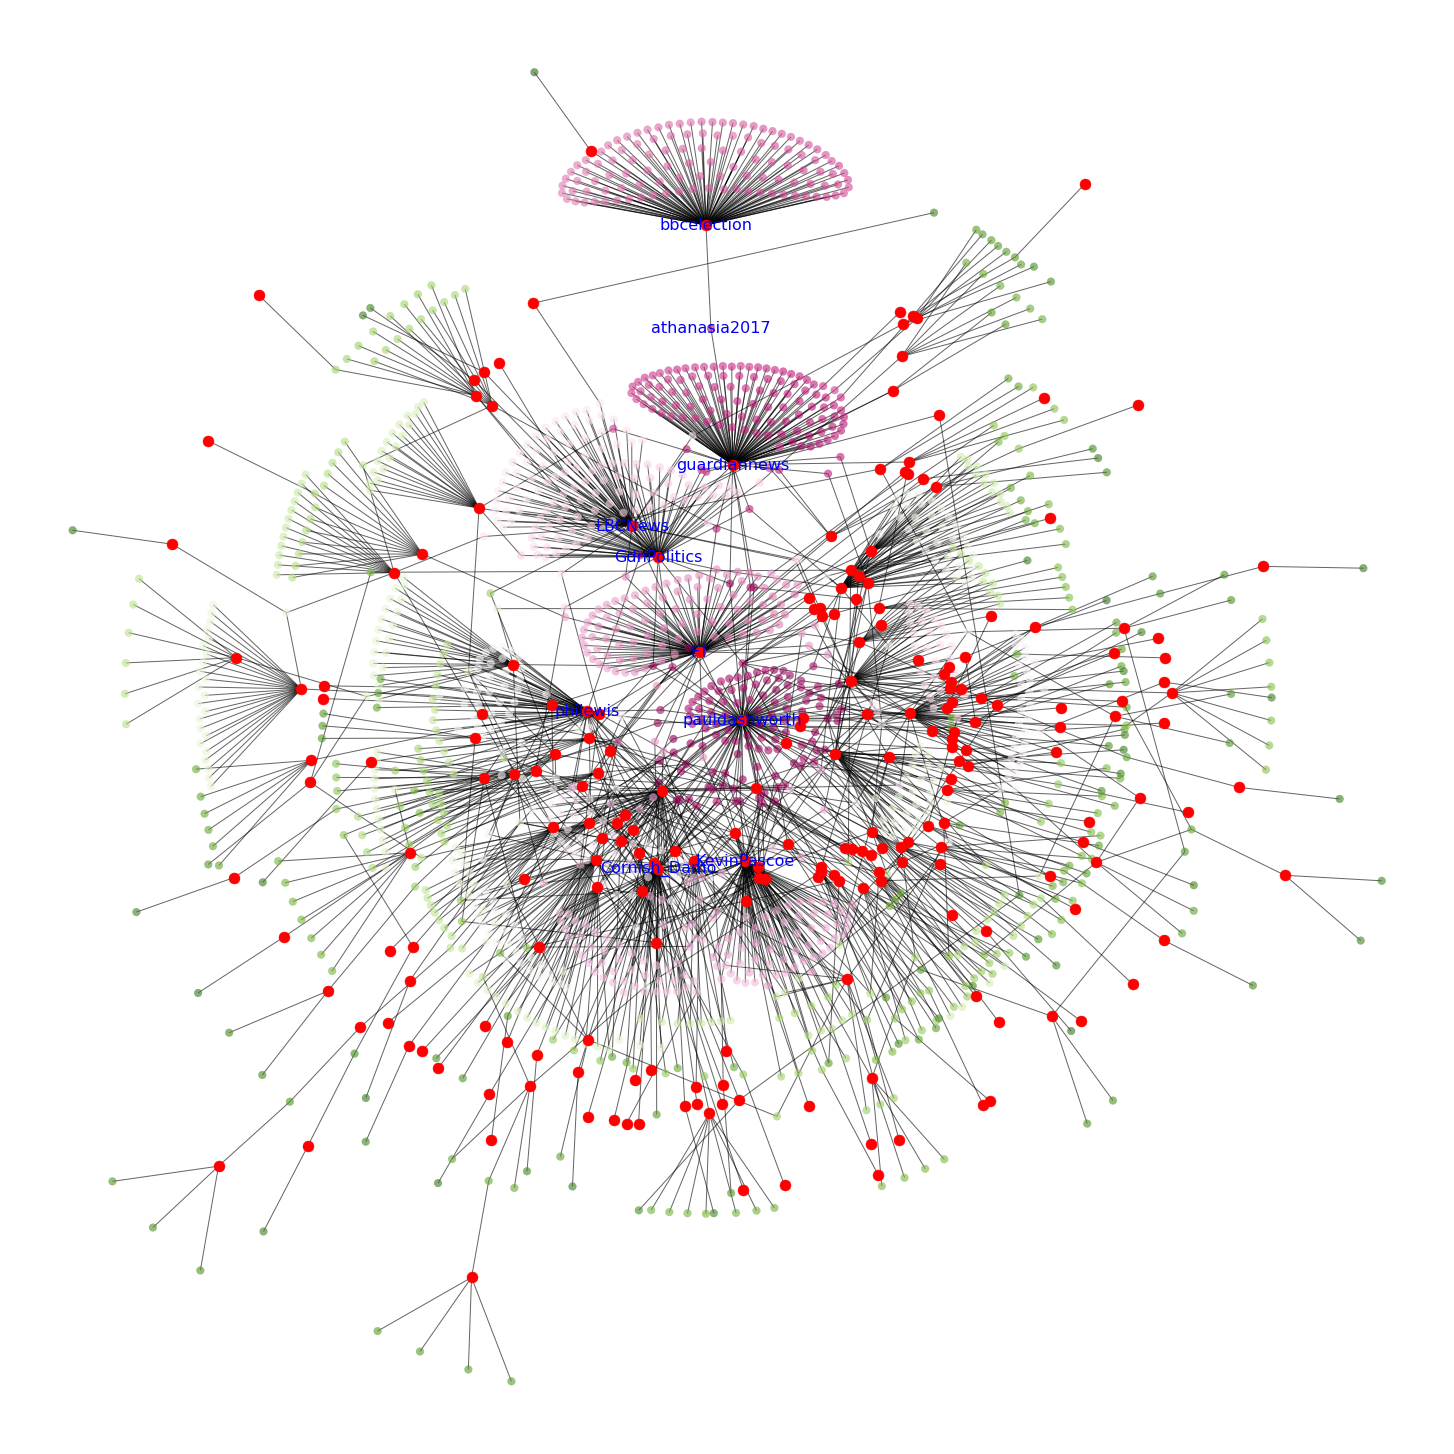

In [108]:
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(1692), cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=120, node_color=colors_central_nodes)
nx.draw_networkx_labels(largest_subgraph, pos=pos, labels=labels, font_size=16, font_color='b')
plt.show()

In [ ]:
from community import community_louvain
partition = community_louvain.best_partition(largest_subgraph)
partition1 = pd.DataFrame([partition]).T
partition1 = partition1.reset_index()
partition1.columns = ['names','group']

In [ ]:
G_sorted = pd.DataFrame(sorted(largest_subgraph.degree, key=lambda x: x[1], reverse=True))
G_sorted.columns = ['names','degree']
G_sorted.head()
dc = G_sorted

In [ ]:
combined = pd.merge(dc,partition1, how='left', left_on="names",right_on="names")

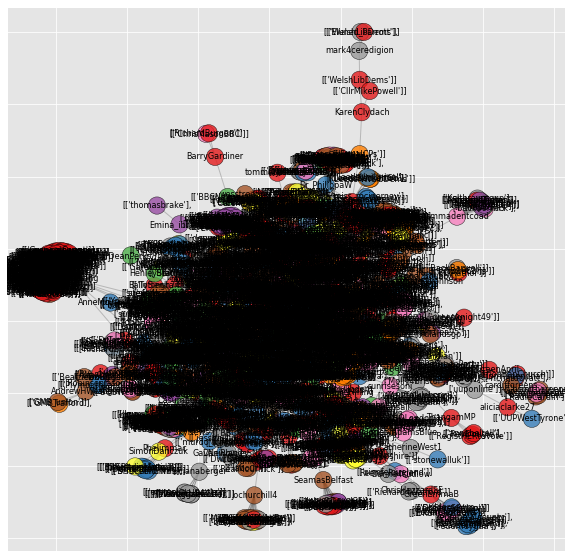

In [ ]:
pos = nx.spring_layout(largest_subgraph)
f, ax = plt.subplots(figsize=(10, 10))
plt.style.use('ggplot')
nodes = nx.draw_networkx_nodes(largest_subgraph, pos,
                               cmap=plt.cm.Set1,
                               node_color=combined['group'],
                               alpha=0.8)
nodes.set_edgecolor('k')
nx.draw_networkx_labels(largest_subgraph, pos, font_size=8)
nx.draw_networkx_edges(largest_subgraph, pos, width=1.0, alpha=0.2)

In [ ]:
edges = nx.to_pandas_edgelist(largest_subgraph)
edges.to_csv("edges.csv")

combined = combined.rename(columns={"names": "Id"})
nodes = combined['Id']
combined.to_csv('nodes.csv')

### Similarity Matrix

In [ ]:
pol_df = pol_df.sample(n=5000)

In [26]:
pol_df = pol_df.reset_index(drop=True)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(pol_df['quotedTweet_content'])
print(tfidf_matrix.shape)

(2895, 11052)


In [28]:
pol_df['quotedTweet_content'][0]

"b'DISGUSTING: Man is given just \\xc2\\xa37 in Universal Credit to get him through Christmas. He has been forced to turn to his poorly mum for meals and is relying on electricity vouchers. GO AND VOTE. #GE2019 #UKElection #BorisOut #ToriesOut #TacticalVoting\\n\\nhttps://t.co/Rq3AwuybsO'"

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_index=cosine_similarity(tfidf_matrix[0],tfidf_matrix)
similarity_index=similarity_index.reshape(-1)

In [30]:
n=6
print(similarity_index[np.argsort(similarity_index)[-n:]])

[0.24647499 0.24647499 1.         1.         1.         1.        ]


In [31]:
res = sorted(range(len(similarity_index)), key = lambda sub: similarity_index[sub])[-n:] 
  
# printing result 
print("Indices list of max N elements is : " + str(res))

Indices list of max N elements is : [8, 9, 0, 2, 11, 12]


In [32]:
for i in res:
    print(pol_df['quotedTweet_content'][i], i)
    print('\n')

b'DISGRACEFUL: Woman on drip forced to lay on chairs for five hours at overcrowded hospital. She suffers from suspected kidney infection, and forced to wait on the makeshift bed. GO AND VOTE. #GE2019 #UKElection #BorisOut #ToriesOut #TacticalVoting\n\nhttps://t.co/CSnUaDYseQ' 8


b'DISGRACEFUL: Woman on drip forced to lay on chairs for five hours at overcrowded hospital. She suffers from suspected kidney infection, and forced to wait on the makeshift bed. GO AND VOTE. #GE2019 #UKElection #BorisOut #ToriesOut #TacticalVoting\n\nhttps://t.co/CSnUaDYseQ' 9


b'DISGUSTING: Man is given just \xc2\xa37 in Universal Credit to get him through Christmas. He has been forced to turn to his poorly mum for meals and is relying on electricity vouchers. GO AND VOTE. #GE2019 #UKElection #BorisOut #ToriesOut #TacticalVoting\n\nhttps://t.co/Rq3AwuybsO' 0


b'DISGUSTING: Man is given just \xc2\xa37 in Universal Credit to get him through Christmas. He has been forced to turn to his poorly mum for meals an

In [35]:
tfidf_matrix

<2895x11052 sparse matrix of type '<class 'numpy.float64'>'
	with 72448 stored elements in Compressed Sparse Row format>

In [33]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(affinity='cosine', linkage='single', distance_threshold=0, n_clusters=None).fit(tfidf_matrix.toarray())


In [37]:
cluster

AgglomerativeClustering(affinity='cosine', distance_threshold=0,
                        linkage='single', n_clusters=None)

In [34]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster 
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

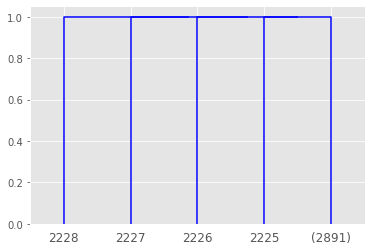

In [35]:
plot_dendrogram(cluster, truncate_mode='level', p=3)
plt.show()

In [36]:
tfidf = TfidfVectorizer(max_features=100)
X = tfidf.fit_transform(pol_df['quotedTweet_content']).todense()

In [38]:
N = X.shape[0]
idx = np.random.choice(N, size=1000, replace=False)
x = X[idx]
labels = pol_df.quotedTweet_username[idx].tolist()


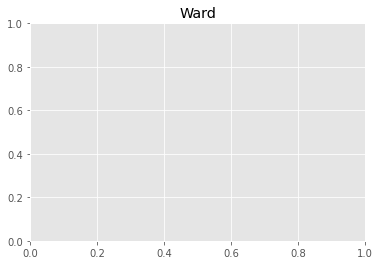

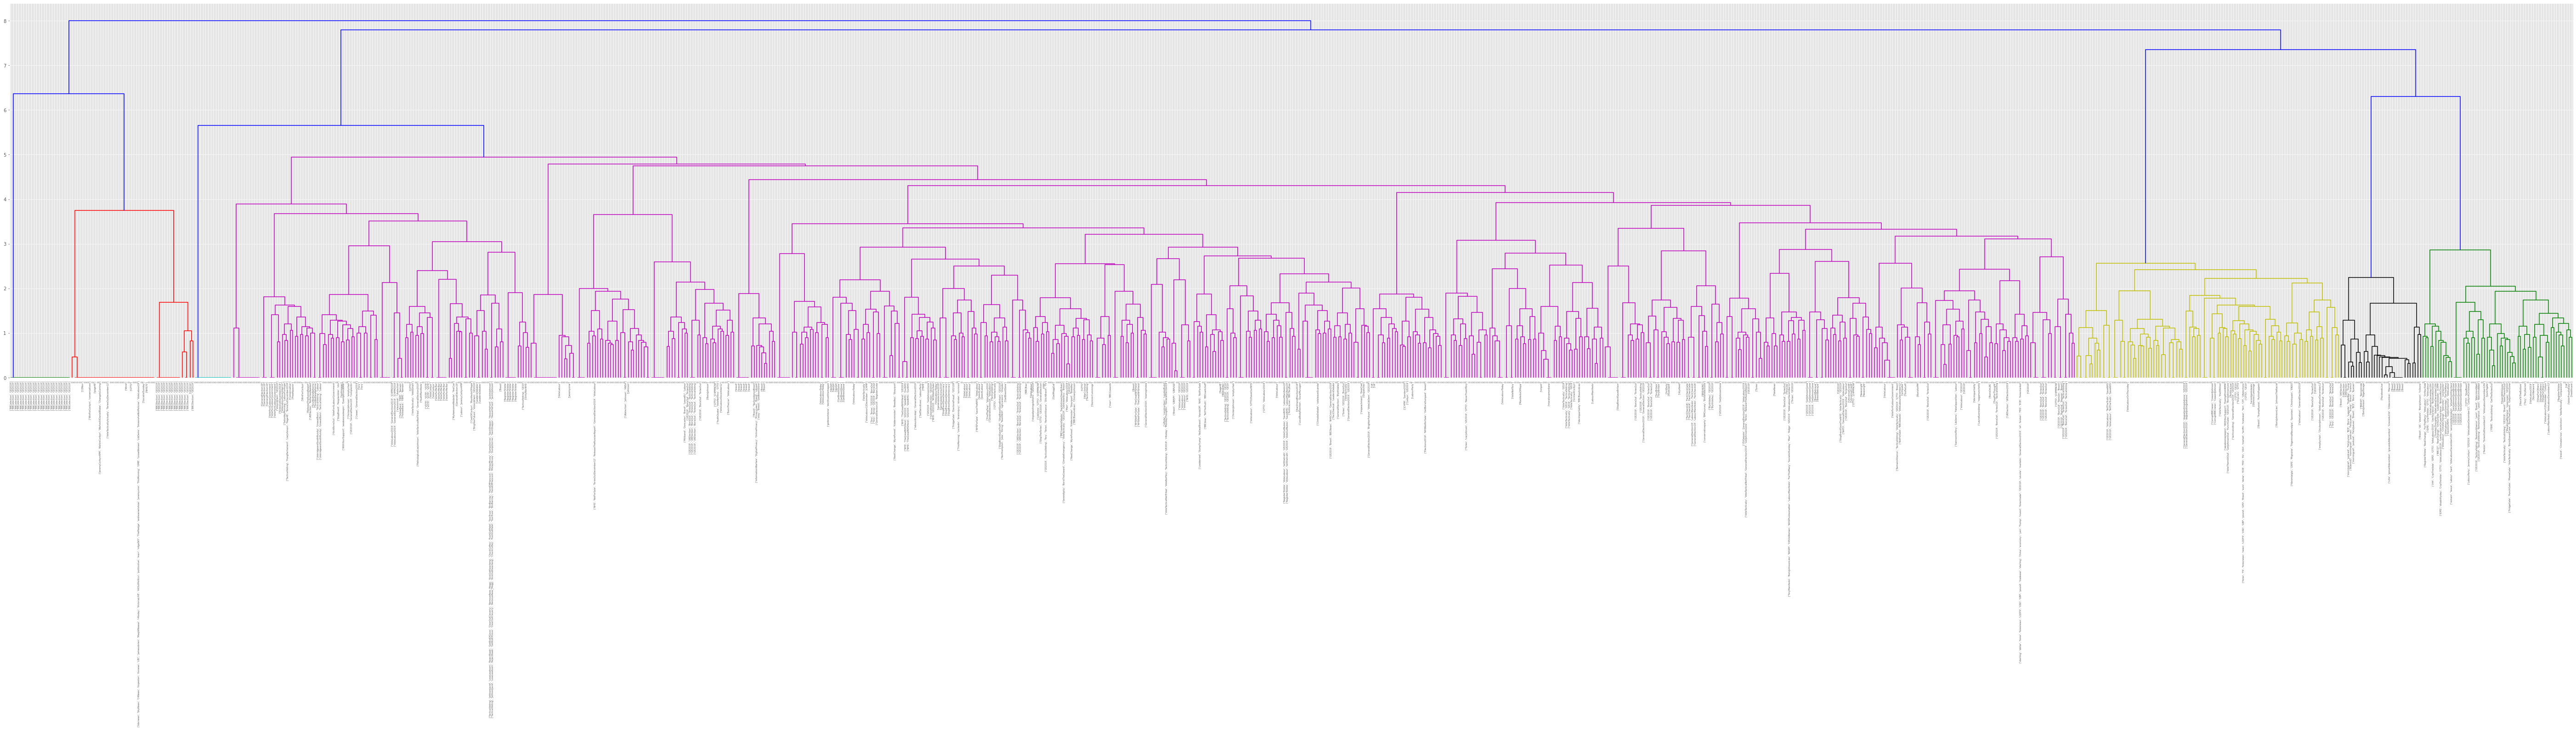

In [39]:
from scipy.spatial.distance import pdist
dist_array = pdist(x)
Z = linkage(dist_array, 'ward')
plt.title("Ward")
plt.figure(figsize = (100,15))
dendrogram(Z, labels=labels)
plt.show()

In [ ]:
dist_array

array([1.36251384, 1.35023272, 1.29156013, ..., 1.37277395, 1.3425914 ,
       1.16012702])

In [ ]:
from sklearn import manifold
